In [67]:
import os, sys
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize, stats

import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [68]:
np.__version__

'1.26.4'

In [69]:
np.set_printoptions(precision=6)

In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
# Load Data
# The first two columns contains the X values and the third column
# contains the label (y).
data = np.loadtxt(os.path.join('Data', 'ex2data2.txt'), delimiter=',')
data.shape

(118, 3)

In [72]:
df = pd.DataFrame({'x1': data[:, 0], 'x2': data[:, 1], 'y': data[:, 2]})
df = df.sample(frac=1, random_state=47).reset_index(drop=True)
df.head()

x1       x2    y
0  0.22984 -0.41155  1.0
1  0.67339  0.64108  0.0
2  0.28744  1.08700  0.0
3 -0.37500  0.50219  1.0
4  0.63882  0.88962  0.0

In [73]:
df['y'].value_counts()

y
0.0    60
1.0    58
Name: count, dtype: int64

In [74]:
data = df.values
data.shape

(118, 3)

In [75]:
X = data[:, [0, 1]]
y = data[:, 2].reshape(X.shape[0], -1)

X.shape, y.shape

((118, 2), (118, 1))

In [76]:
X.ndim

2

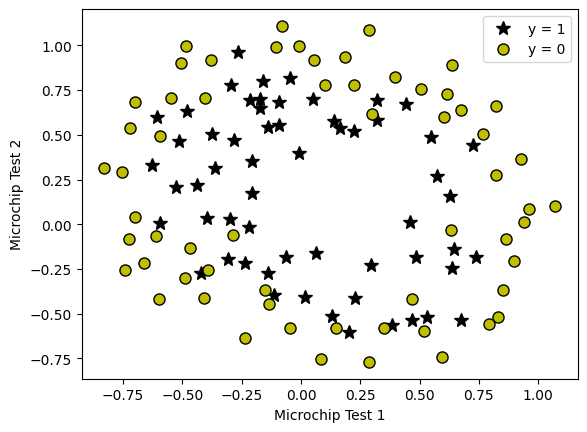

In [77]:
# plot the data
fig = pyplot.figure()


pos = y == 1
neg = y == 0

pos = pos.reshape(X.shape[0], )
neg = neg.reshape(X.shape[0], )

pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)

# Labels and Legend
pyplot.xlabel('Microchip Test 1')
pyplot.ylabel('Microchip Test 2')

# Specified in plot order
pyplot.legend(['y = 1', 'y = 0'], loc='upper right')

plt.show()

In [78]:
ones = np.ones((X.shape[0], 1))
ones.shape

(118, 1)

In [79]:
x1 = X[:, 0].reshape(X.shape[0], -1)
x2 = X[:, 1].reshape(X.shape[0], -1)

x1.shape, x2.shape

((118, 1), (118, 1))

In [80]:
# out = []

# out.append(x1)
# out.append(x2)

In [81]:
# x1

In [82]:
# x2

In [83]:
# np.squeeze(np.stack(out, axis=0)).T

In [84]:
# let's get the polynomial features
# x1^2, x1*x2, x2^2 ... x2^6

def feature_mapping(x1, x2, degree=6):
    out = []
    
    for i in range(1, degree+1):
        for j in range(i+1):
            x = (x1 ** (i-j)) * (x2 ** j)
            out.append(x)
    
    return np.squeeze(np.stack(out, axis=0)).T

In [85]:
feature_mapping(x1, x2).shape

(118, 27)

In [86]:
features = np.hstack((ones, feature_mapping(x1, x2)))
features.shape

(118, 28)

In [87]:
features

array([[ 1.000000e+00,  2.298400e-01, -4.115500e-01, ...,  1.515450e-03,
        -2.713555e-03,  4.858874e-03],
       [ 1.000000e+00,  6.733900e-01,  6.410800e-01, ...,  7.659179e-02,
         7.291683e-02,  6.941820e-02],
       [ 1.000000e+00,  2.874400e-01,  1.087000e+00, ...,  1.153487e-01,
         4.362093e-01,  1.649595e+00],
       ...,
       [ 1.000000e+00,  8.519600e-01, -3.676900e-01, ...,  1.326678e-02,
        -5.725696e-03,  2.471103e-03],
       [ 1.000000e+00, -3.980400e-01,  3.435700e-02, ...,  2.207569e-07,
        -1.905473e-08,  1.644718e-09],
       [ 1.000000e+00, -3.058800e-01, -1.922500e-01, ...,  1.278108e-04,
         8.033094e-05,  5.048915e-05]])

In [88]:
y.shape

(118, 1)

In [89]:
# let's define the sigmoid

def sigmoid(Z: np.array):
    g = 1. / (1. + np.exp(-Z))
    
    return g

In [94]:
# let's define the cost and gradient functions

def cost_fn(theta: np.array, X_train: np.array, y_train: np.array, lambda_: float, m: int):
    # let's make the X and y in correct shape for matrix operations
    X_train = X_train.T
    y_train = y_train.T
    
    # now let's calculate the hypothesis
    h = sigmoid(np.dot(theta.T, X_train))
    
    first_term = np.sum(y_train * np.log(h))
    second_term = np.sum((1 - y_train) * (np.log(1-h)))
    
    regularization_term = (lambda_/(2*m)) * np.dot(theta.T, theta)
    
    cost = (-1./m) * (first_term + second_term) + regularization_term
    
    return cost.item()


def gradient_fn(theta: np.array, X_train: np.array, y_train: np.array, lambda_: float, m: int):
    # let's make X and y in correct shape for matrix operations
    X_train = X_train.T
    y_train = y_train.T
    
    # now, let's calculate the hypothesis fn
    h = sigmoid(np.dot(theta.T, X_train))
    
    # h(X) - y
    diff = h - y_train
    
    reg_term = (lambda_/m) * theta
    
    gradient = (1./m) * np.dot(X_train, diff.T) + reg_term
    
    return gradient

In [103]:

def train(X_train, y_train, n_iterations: int=10000, lr: float=0.001, lambda_=0.1):
    # Initialize theta
    theta = stats.uniform.rvs(0, 1, size=(X_train.shape[1], 1))
    #theta = np.zeros((X_train.shape[0], 1))
    
    # to plot the cost over the iteration
    costs = []
    
    for i in range(n_iterations):
        cost = cost_fn(theta=theta, X_train=X_train, y_train=y_train, m=X_train.shape[1], lambda_=lambda_)
        costs.append(cost)
        
        if (i % 10) == 0:
            print(f"The cost at {i}th iteration is {cost}")
            print(f"Theta: {theta.T}")
            print("************************************************\n")
        
        gradient = gradient_fn(theta=theta, X_train=X_train, y_train=y_train, m=X_train.shape[1], lambda_=lambda_)
        
        # update the theta 
        theta = theta - (lr * gradient)
    
    return theta, np.array(costs)

In [163]:
# no regularization (lambda_=0)

n_iterations = 50000

opt_theta, costs = train(X_train=features,
                    n_iterations=n_iterations, 
                    y_train=y,
                    lr=0.001,
                    lambda_=0)  

The cost at 0th iteration is 4.844266661449318
Theta: [[0.325111 0.810693 0.753359 0.687417 0.732611 0.495215 0.156299 0.471613
  0.003532 0.051292 0.842655 0.024539 0.034898 0.265207 0.148955 0.167253
  0.8803   0.550298 0.335244 0.404441 0.205326 0.655299 0.676035 0.113808
  0.862235 0.149343 0.313553 0.701234]]
************************************************

The cost at 10th iteration is 4.819964960234885
Theta: [[0.316027 0.807479 0.749463 0.682527 0.731834 0.490094 0.153978 0.470647
  0.002753 0.047724 0.839354 0.02428  0.033738 0.26495  0.144908 0.165253
  0.879852 0.549939 0.334663 0.404101 0.201973 0.652797 0.67588  0.113292
  0.862153 0.148729 0.31344  0.697637]]
************************************************

The cost at 20th iteration is 4.795957552386165
Theta: [[0.307042 0.804262 0.745585 0.677659 0.731049 0.485004 0.151658 0.469683
  0.001972 0.044171 0.836063 0.024018 0.032582 0.26469  0.140878 0.163254
  0.879405 0.549581 0.334084 0.403759 0.198632 0.6503   0.675724

In [158]:

# Plot the cost over iterations
def plot_cost_over_iterations(n_iterations, costs, lambda_val=0):
    """
    Plots the cost function over iterations.

    Parameters:
    ----------
    n_iterations : int
        Number of iterations during training.

    costs : array_like
        Array containing the cost at each iteration.

    lambda_val : float, optional
        Regularization parameter value, default is 0 (no regularization).

    Returns:
    -------
    None
    """
    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the costs over iterations
    plt.plot(range(n_iterations), costs, color='b', linewidth=2, label='Cost')

    # Customizing the plot
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Cost', fontsize=14)
    plt.title(f'Cost Function Over Iterations (Regularization λ = {lambda_val})', fontsize=16)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a legend
    plt.legend(loc='best', fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()
    

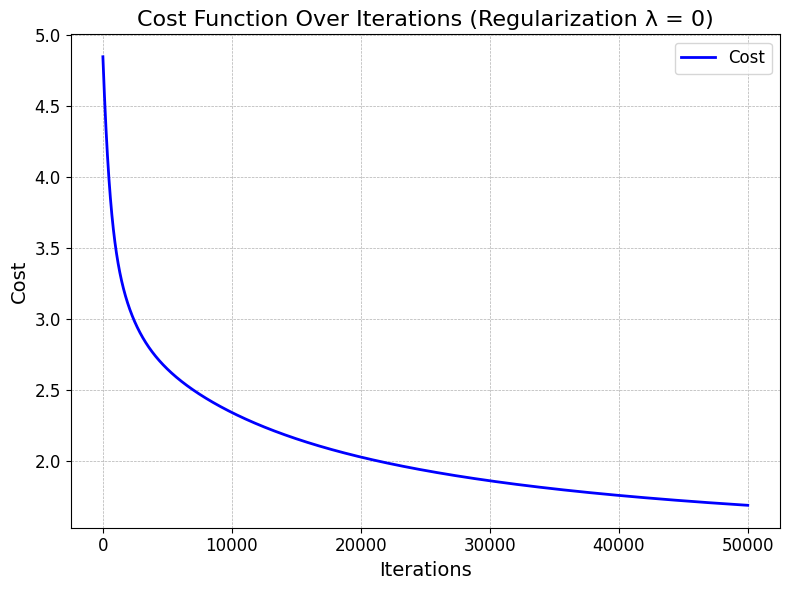

In [164]:
# Example usage (assuming n_iterations and costs are defined)
plot_cost_over_iterations(n_iterations, costs, lambda_val=0)

In [165]:
opt_theta

array([[ 1.884477],
       [ 1.311841],
       [ 2.08119 ],
       [-3.245903],
       [-1.728819],
       [-2.055835],
       [ 0.125882],
       [-0.717302],
       [-0.968916],
       [-0.504143],
       [-2.174665],
       [-0.438292],
       [-1.19077 ],
       [-0.610477],
       [-2.135015],
       [-0.505013],
       [ 0.191391],
       [ 0.366913],
       [-0.331245],
       [-0.367712],
       [-0.803012],
       [-1.59961 ],
       [ 0.510428],
       [-0.488492],
       [ 0.749328],
       [-0.507984],
       [-0.183632],
       [-1.165421]])

In [166]:
def mapFeature(X1, X2, degree=6):
    """
    Maps the two input features to polynomial features.
    """
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]

    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out)

# Function to plot decision boundary
def plotDecisionBoundary(theta, X, y, degree=6, lambda_val=1.0):
    """
    Plots the data points X and y with a non-linear decision boundary defined by theta.
    """
    # Plot data
    pos = y == 1
    neg = y == 0
    
    pos = pos.reshape(X.shape[0], )
    neg = neg.reshape(X.shape[0], )
    
    plt.scatter(X[pos, 0], X[pos, 1], c='k', marker='*', label="y=1", s=100)
    plt.scatter(X[neg, 0], X[neg, 1], c='yellow', marker='o', edgecolor='k', label="y=0", s=80)

    # Set axis labels and title
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.title(f'lambda (λ) = {lambda_val:.2f}')

    # Define grid range for plotting decision boundary
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    
    z = np.zeros((u.size, v.size))
    
    # Compute z values for each point in the grid
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            z[i, j] = np.dot(mapFeature(np.array([ui]), np.array([vj]), degree), theta)
    
    z = z.T  # Transpose z to correctly plot the contour

    # Plot decision boundary as a contour
    plt.contour(u, v, z, levels=[0], linewidths=2, colors='g')
    plt.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.3)

    plt.legend(loc='upper right')
    plt.xlim([-1, 1.5])
    plt.ylim([-1, 1.5])
    plt.grid(True)
    plt.show()

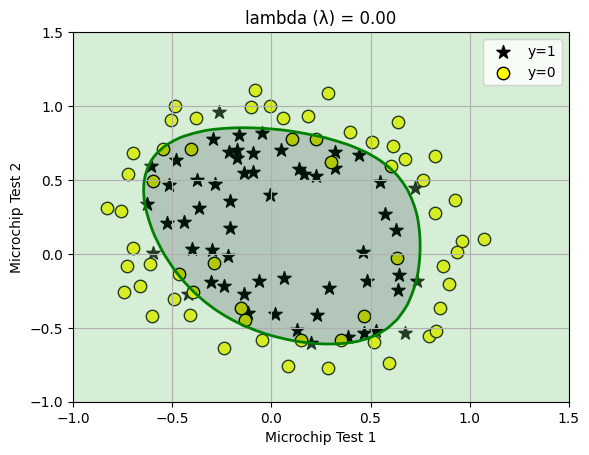

In [167]:
# Example usage (assuming opt_theta and X, y are defined):
plotDecisionBoundary(opt_theta, X, y, degree=6, lambda_val=0.0)

In [154]:
# regularization (lambda_=1)

n_iterations = 50000

opt_theta_reg, costs_reg = train(X_train=features,
                    n_iterations=n_iterations, 
                    y_train=y,
                    lr=0.001,
                    lambda_=1.0)  

The cost at 0th iteration is 5.9053598973914925
Theta: [[0.812615 0.424782 0.896876 0.931048 0.891868 0.300209 0.164167 0.782886
  0.362829 0.008191 0.556639 0.052833 0.99261  0.334424 0.191331 0.687597
  0.314454 0.791206 0.270035 0.045738 0.708733 0.698593 0.704771 0.186868
  0.669309 0.971132 0.349474 0.58658 ]]
************************************************

The cost at 10th iteration is 5.8664961937036875
Theta: [[0.79945  0.422099 0.892093 0.92499  0.891044 0.294046 0.161957 0.781557
  0.362048 0.004215 0.552806 0.052649 0.990932 0.334179 0.186758 0.685397
  0.313874 0.790592 0.269303 0.045452 0.704837 0.695675 0.704407 0.186229
  0.669026 0.970102 0.349315 0.582477]]
************************************************

The cost at 20th iteration is 5.828038313180083
Theta: [[7.863928e-01 4.194127e-01 8.873204e-01 9.189561e-01 8.902104e-01
  2.879125e-01 1.597485e-01 7.802293e-01 3.612657e-01 2.487478e-04
  5.489832e-01 5.246346e-02 9.892583e-01 3.339311e-01 1.821991e-01
  6.83199

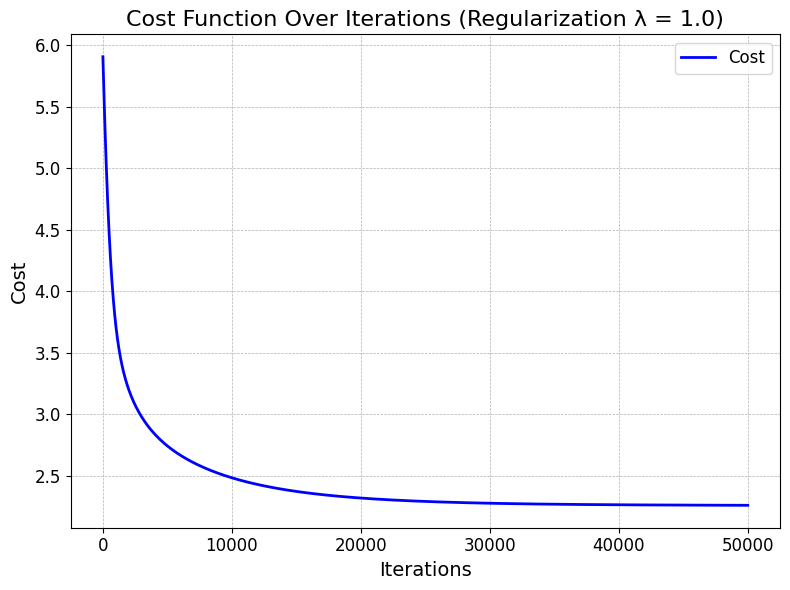

In [155]:
# Example usage (assuming n_iterations and costs are defined)
plot_cost_over_iterations(n_iterations, costs_reg, lambda_val=1.0)

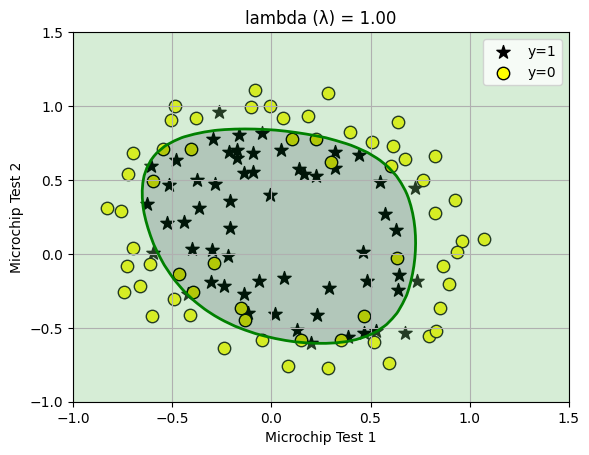

In [156]:
# Example usage (assuming opt_theta and X, y are defined):
plotDecisionBoundary(opt_theta_reg, X, y, degree=6, lambda_val=1.0)

##### Using Scikit-learn

In [111]:
from sklearn.linear_model import LogisticRegression

In [139]:
# Default Solver: The default value of the solver parameter is 'lbfgs'.
model = LogisticRegression(solver='lbfgs')

# Train the model (assuming you've already trained the model with .fit())
model.fit(features[:, 1:], y)

# Get the coefficients (weights) for each feature
coefficients = model.coef_

# Get the intercept (bias term or theta_0)
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[ 0.624392  1.17925  -2.018975 -0.912665 -1.431648  0.12422  -0.366311
  -0.357705 -0.173231 -1.459105 -0.050759 -0.617146 -0.273365 -1.192936
  -0.24253  -0.206507 -0.04555  -0.277868 -0.295651 -0.455544 -1.044718
   0.027518 -0.293217  0.015393 -0.328055 -0.143643 -0.925376]]
Intercept: [1.272908]


In [140]:
opt_theta_lbfgs = np.vstack((intercept, coefficients.T))

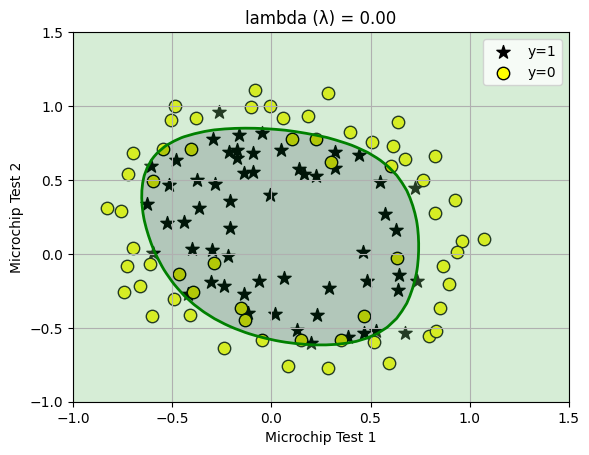

In [141]:
plotDecisionBoundary(opt_theta_lbfgs, X, y, degree=6, lambda_val=0.0)

In [113]:
model1 = LogisticRegression(solver='saga', max_iter=1000)

# Train the model (assuming you've already trained the model with .fit())
model1.fit(features[:, 1:], y)

# Get the coefficients (weights) for each feature
coefficients = model1.coef_

# Get the intercept (bias term or theta_0)
intercept = model1.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[ 0.625165  1.180939 -2.019152 -0.916539 -1.430194  0.123964 -0.365725
  -0.357729 -0.175017 -1.458214 -0.051602 -0.615627 -0.274509 -1.192788
  -0.242139 -0.206332 -0.045376 -0.277718 -0.295416 -0.456927 -1.043325
   0.027348 -0.292612  0.015118 -0.327365 -0.143763 -0.925322]]
Intercept: [1.272278]


In [134]:
coefficients.T.shape, intercept.shape

((27, 1), (1,))

In [137]:
opt_theta_saga = np.vstack((intercept, coefficients.T))

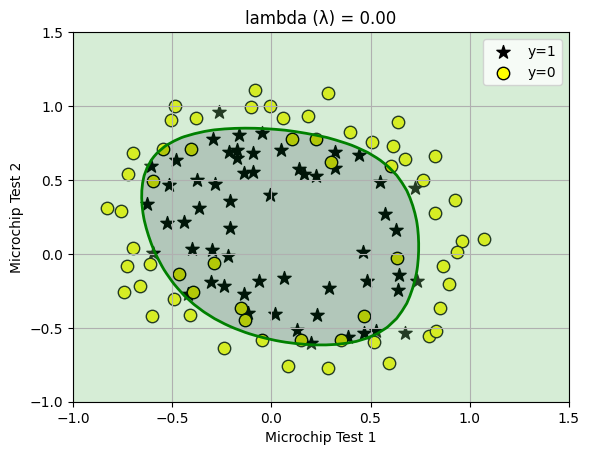

In [138]:
plotDecisionBoundary(opt_theta_saga, X, y, degree=6, lambda_val=0.0)